In [1]:
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=4)

# runs the util notebook so that those functions are available
%run utils.ipynb

* Split data into test train split
* Do a baseline default settings SVM model with linear one against the rest
* Iterating through runs of SVM with different hyperparameters to find the best hyperparameters, using GridSearch. 
* Baseline with linear SVM, and *then explore options for nonlinear SVM. 
* Select the best model and justify
* Test accuracy of best model

In [2]:
X, y, features = load_standardized_beans()
X_train, X_valid, X_test, y_train, y_valid, y_test =  split(X,y)

In [5]:
# Doing a baseline SVM, with the default parameters. Default C is 1.0
classifier = svm.SVC(kernel="linear")

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_valid)
print('accuracy: ', np.mean(y_valid == y_pred))

accuracy:  0.9305912596401028


In [6]:
# But let's do cross validation, and with Stratified K folds, to makes sure we have a good sense of the baseline. 
# I've put this into a function to make sure that we test these classifiers in a consistent manner. 

test_classifier(classifier, X, y)

Classifier type: SVC
Classifier paramaters:  {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Classifier accuracy:  0.9257218086439757


Scikit Learn's documentation says that the One Versus One option for the decision_function_shape argument is deprecated, and that One Versus Rest is both recommended and the default. Doesn't seem to change the results much, so moving forward we will leave it with the default that the package recommends, the One Versus Rest. 

In [7]:
classifier = svm.SVC(kernel="linear", decision_function_shape='ovo')

test_classifier(classifier, X, y)

Classifier type: SVC
Classifier paramaters:  {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Classifier accuracy:  0.9261620673269828


Just to verify our assumption, before we proceed forward, that the standardized data provides a benifit over the raw data:

In [18]:
%%cache

# Trying SVM classification with the non-standardized data

X, y, features = load_beans()

classifier = svm.SVC(kernel="linear")
test_classifier(classifier, X, y)

Classifier type: SVC
Classifier paramaters:  {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


Yes. It looks like the standardized data provides some accuracy benefit over the raw data. Maybe the biggest improvement is with computation time. Regardless, we will leave the raw data behind now, and only work with the standardized data. 

In [8]:
X, y, features = load_standardized_beans()


Now that we have established a baseline model accuracy of **92.6%** using a linear SVM model with scikit learn's defaults and a standardized dataset, we will proceed to tuning our hyperparameters and seeing if we can find a better model for predicting the dry bean varieties. 

In [5]:
C_list = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
accuracy = []
for C in C_list :
    classifier = svm.SVC(kernel="linear", C=C)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy.append(np.mean(y_test == y_pred))

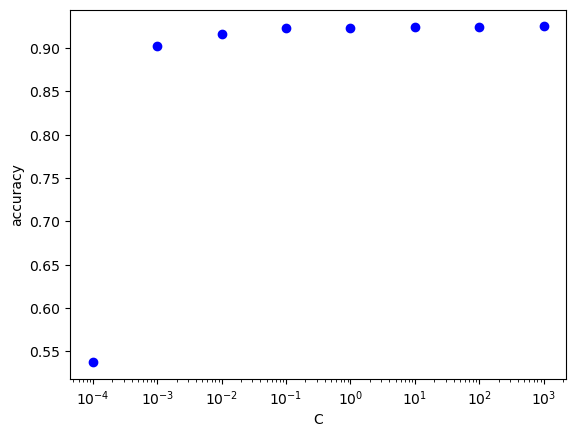

In [6]:
plt.semilogx(C_list, accuracy, 'ob')
plt.xlabel('C')
plt.ylabel('accuracy');

In [7]:
accuracy

[0.5373499877541024,
 0.9015429831006613,
 0.9164829782023022,
 0.9223610090619643,
 0.9233406808719079,
 0.9235855988243938,
 0.9245652706343375,
 0.9248101885868234]

In [14]:
# warning - runs for a long time!

from sklearn.model_selection import GridSearchCV
gammas = np.logspace(-6, 3, num=10, endpoint=True, base=10.0)
Cs = np.logspace(-6, 3, num=10, endpoint=True, base=10.0)
# the following defines two grids - one for the linear kernel
# and a second grid for the Gaussian kernel
param_grid = [
  {'C': Cs,
   'kernel': ['linear']}, 
  {'C': Cs,
   'gamma': gammas,
   'kernel': ['rbf']},
  {'C': Cs,
  'gamma': gammas,
   'degree': [1,2,3,4],
   'kernel': ['poly']},
 ]

# instantiate a GridSearchCV object with SVM as the underlying classifier
# with the grid defined above
gridclassifier = GridSearchCV(svm.SVC(), param_grid, cv=stratcv )

gridclassifier.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': [0.001, 0.01], 'kernel': ['linear']},
                         {'C': [0.001, 0.01], 'gamma': [0.01, 0.1],
                          'kernel': ['rbf']},
                         {'C': [0.001, 0.01], 'degree': [1, 2],
                          'gamma': [0.01, 0.1], 'kernel': ['poly']}])

In [21]:
gridclassifier.best_estimator_

SVC(C=0.01, kernel='linear')

In [22]:
gridclassifier.best_params_

{'C': 0.01, 'kernel': 'linear'}

In [23]:
gridclassifier.best_score_

0.92293004080137

In [20]:
import pandas as pd

results = pd.DataFrame({
    'Parameters': gridclassifier.cv_results_['params'],
    'Mean Accuracy': gridclassifier.cv_results_['mean_test_score'],
    'Std Dev Accuracy': gridclassifier.cv_results_['std_test_score']
    })

results = results.sort_values(by='Mean Accuracy', ascending=False)
results.to_csv('gridsearch_results.csv')

In [25]:
classifier = svm.SVC(kernel="linear", C=.01)

test_classifier(classifier, X, y)

Classifier type: SVC
Classifier paramaters:  {'C': 0.01, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Classifier accuracy:  0.9229300138181216
